In [1]:
# encoding=utf-8
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "./input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from lightgbm import LGBMClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict

train = pd.read_csv("../input/application_train.csv")
test = pd.read_csv("../input/application_test.csv")
bureau = pd.read_csv("../input/bureau.csv")
previous_app  = pd.read_csv("../input/previous_application.csv")
bureau_balance = pd.read_csv("../input/bureau_balance.csv")
credit_cb = pd.read_csv("../input/credit_card_balance.csv")
installments_pay = pd.read_csv("../input/installments_payments.csv")
POS_CASH_b = pd.read_csv("../input/POS_CASH_balance.csv")

['previous_application.csv', 'home-credit-default-risk.zip', 'bureau.csv', 'installments_payments.csv', 'credit_card_balance.csv', 'bureau_balance.csv', 'save-dromosys-features', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'application_test.csv', 'sample_submission.csv', 'application_train.csv']


In [2]:
ID = test.SK_ID_CURR

le = LabelEncoder()
bureau_cat_features = [f for f in bureau.columns if bureau[f].dtype == 'object']
for f in bureau_cat_features:
    bureau[f] = le.fit_transform(bureau[f].astype(str))
    nunique = bureau[['SK_ID_CURR', f]].groupby('SK_ID_CURR').nunique()
    bureau['NUNIQUE_'+f] = nunique[f]
    bureau.drop([f], axis=1, inplace=True)
bureau = bureau.drop(['AMT_ANNUITY'],axis=1)


bureau_balance['STATUS'] = le.fit_transform(bureau_balance['STATUS'].astype(str))
nunique2 = bureau_balance[['SK_ID_BUREAU','MONTHS_BALANCE']].groupby('SK_ID_BUREAU').min().reset_index().astype(int)
nunique = bureau_balance[['SK_ID_BUREAU','STATUS']].groupby('SK_ID_BUREAU').nunique()
nunique2['STATUS'] = nunique['STATUS'].values
nunique2['SK_ID_BUREAU'] = nunique2['SK_ID_BUREAU'].astype(np.int64)


bureaumg = bureau.merge(nunique2, how='left', on='SK_ID_BUREAU')
bureaumg.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
bureaumg.MONTHS_BALANCE = bureaumg.MONTHS_BALANCE.fillna('0')
bureaumg.STATUS = bureaumg.STATUS.fillna('0')
bureaumg.MONTHS_BALANCE = bureaumg.MONTHS_BALANCE.astype(int)
bureaumg.STATUS = bureaumg.STATUS.astype(int)
bureaumg[['AMT_CREDIT_MAX_OVERDUE','AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM_LIMIT','NUNIQUE_CREDIT_ACTIVE','NUNIQUE_CREDIT_CURRENCY','NUNIQUE_CREDIT_TYPE']] = bureaumg[['AMT_CREDIT_MAX_OVERDUE','AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM_LIMIT','NUNIQUE_CREDIT_ACTIVE','NUNIQUE_CREDIT_CURRENCY','NUNIQUE_CREDIT_TYPE']].fillna(0)
bureaugroup = bureaumg.groupby('SK_ID_CURR').mean().reset_index()


train = train.merge(bureaugroup,how='left', on='SK_ID_CURR')
test = test.merge(bureaugroup,how='left', on='SK_ID_CURR')
#
POS_cat_features = [f for f in POS_CASH_b.columns if POS_CASH_b[f].dtype == 'object']
for f in POS_cat_features:
    POS_CASH_b[f] = le.fit_transform(POS_CASH_b[f].astype(str))
    nunique = POS_CASH_b[['SK_ID_CURR', f]].groupby('SK_ID_CURR').nunique()
    POS_CASH_b['NUNIQUE_'+f] = nunique[f]
    POS_CASH_b.drop([f], axis=1, inplace=True)
POS_CASH_b.drop(['SK_ID_PREV'], axis=1, inplace=True)
credit_cb_cat_features = [f for f in credit_cb.columns if credit_cb[f].dtype == 'object']
for f in credit_cb_cat_features:
    credit_cb[f] = le.fit_transform(credit_cb[f].astype(str))
    nunique = credit_cb[['SK_ID_CURR', f]].groupby('SK_ID_CURR').nunique()
    credit_cb['NUNIQUE_'+f] = nunique[f]
    credit_cb.drop([f], axis=1, inplace=True)
credit_cb.drop(['SK_ID_PREV'], axis=1, inplace=True)
installments_pay_cat_features = [f for f in installments_pay.columns if installments_pay[f].dtype == 'object']
for f in installments_pay_cat_features:
    installments_pay[f] = le.fit_transform(installments_pay[f].astype(str))
    nunique = installments_pay[['SK_ID_CURR', f]].groupby('SK_ID_CURR').nunique()
    installments_pay['NUNIQUE_'+f] = nunique[f]
    installments_pay.drop([f], axis=1, inplace=True)
installments_pay.drop(['SK_ID_PREV'], axis=1, inplace=True)

train = train.merge(POS_CASH_b.groupby('SK_ID_CURR').mean().reset_index(),how='left', on='SK_ID_CURR')
test = test.merge(POS_CASH_b.groupby('SK_ID_CURR').mean().reset_index(),how='left', on='SK_ID_CURR')
train = train.merge(credit_cb.groupby('SK_ID_CURR').mean().reset_index(),how='left', on='SK_ID_CURR')
test = test.merge(credit_cb.groupby('SK_ID_CURR').mean().reset_index(),how='left', on='SK_ID_CURR')
train = train.merge(installments_pay.groupby('SK_ID_CURR').mean().reset_index(),how='left', on='SK_ID_CURR')
test = test.merge(installments_pay.groupby('SK_ID_CURR').mean().reset_index(),how='left', on='SK_ID_CURR')

previous_app_cat_features = [f for f in previous_app.columns if previous_app[f].dtype == 'object']
for f in previous_app_cat_features:
    previous_app[f] = le.fit_transform(previous_app[f].astype(str))
    nunique = previous_app[['SK_ID_CURR', f]].groupby('SK_ID_CURR').nunique()
    previous_app['NUNIQUE_'+f] = nunique[f]
    previous_app.drop([f], axis=1, inplace=True)
previous_app.drop(['SK_ID_PREV'], axis=1, inplace=True)
previous_app.drop(['RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED'], axis=1, inplace=True)
previous_app.fillna(0,inplace=True)
train = train.merge(previous_app.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(previous_app.groupby('SK_ID_CURR').mean().reset_index(),how='left', on='SK_ID_CURR')
#

Y=train.TARGET
drop1 = ['SK_ID_CURR','OWN_CAR_AGE','OCCUPATION_TYPE','APARTMENTS_AVG','BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG','COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG','LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE','FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE','HOUSETYPE_MODE','TOTALAREA_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE']
drop2 = ['CNT_CHILDREN','REGION_RATING_CLIENT','FLAG_DOCUMENT_2','LIVE_REGION_NOT_WORK_REGION','LIVE_CITY_NOT_WORK_CITY','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']
drop3 = ['DAYS_ENDDATE_FACT','AMT_CREDIT_MAX_OVERDUE','AMT_CREDIT_SUM_LIMIT','AMT_ANNUITY_y']
train.drop(drop1,axis=1,inplace=True)
test.drop(drop1,axis=1,inplace=True)
train.drop(drop2,axis=1,inplace=True)
test.drop(drop2,axis=1,inplace=True)
train.drop(drop3,axis=1,inplace=True)
test.drop(drop3,axis=1,inplace=True)

all_data = pd.concat((train, test))
#处理数据
train['DAYS_BIRTH'] = -(train['DAYS_BIRTH']/365).astype(int)
test['DAYS_BIRTH'] = -(test['DAYS_BIRTH']/365).astype(int)

#缺失值
#如果数字，填写均值。如果字符串，填写次数最多的
for col in train.columns:
    if train[col].isnull().sum() > 0:
        if train[col].dtypes == 'object':
            val = all_data[col].dropna().value_counts().idxmax()
            train[col] = train[col].fillna(val)
        else:
            val = all_data[col].dropna().mean()
            train[col] = train[col].fillna(val)

for col in test.columns:
     if test[col].isnull().sum() > 0:
         if test[col].dtypes == 'object':
             val = all_data[col].dropna().value_counts().idxmax()
             test[col] = test[col].fillna(val)
         else:
             val = all_data[col].dropna().mean()
             test[col] = test[col].fillna(val)


#变哑变量
for col in all_data.select_dtypes(include = [object]).columns:
      train[col] = train[col].astype('category', categories = all_data[col].dropna().unique())
      test[col] = test[col].astype('category', categories = all_data[col].dropna().unique())



for col in train.columns:
      if train[col].dtype.name == 'category':
         tmp = pd.get_dummies(train[col], prefix = col)
         train = train.join(tmp)
         train = train.drop(col, axis=1)



for col in test.columns:
      if test[col].dtype.name == 'category':
           tmp = pd.get_dummies(test[col], prefix = col)
           test = test.join(tmp)
           test = test.drop(col, axis=1)

In [3]:
#model training
X = train.drop('TARGET',axis=1)    
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,test_size=0.2)


In [4]:
clf = LGBMClassifier(
        learning_rate=0.1,
        n_estimators=310,
        num_leaves=15,
        colsample_bytree=.8,
        subsample=.8,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01
    )
clf.fit(Xtrain,Ytrain)
prodict_prob_y= clf.predict_proba(Xtest)[:, 1]
test_auc = metrics.roc_auc_score(Ytest,prodict_prob_y)
test_auc

0.7779986419993006

/home/yhf/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/yhf/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


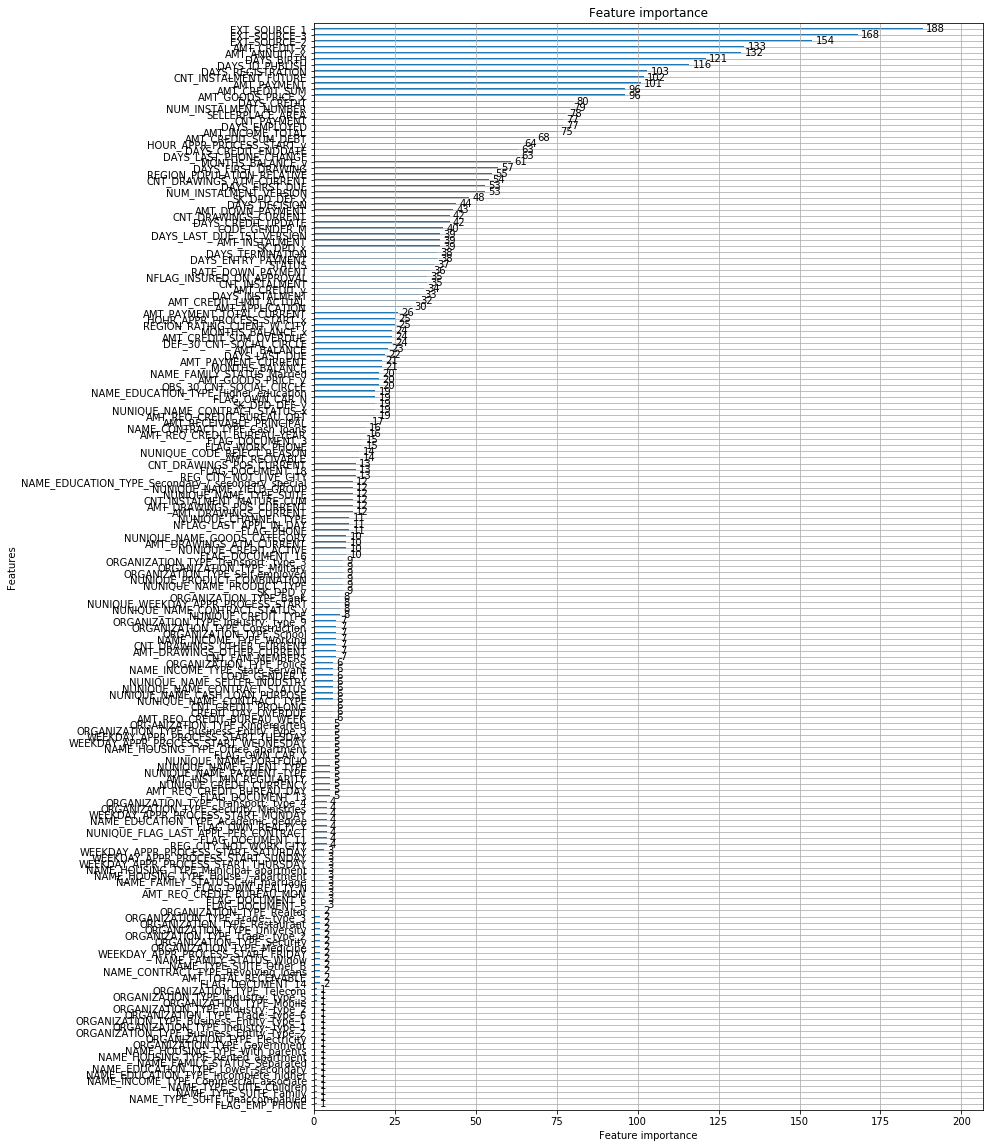

In [5]:
lgb.plot_importance(clf, figsize=(12, 20))
clf.score(Xtrain,Ytrain)
clf.score(Xtest,Ytest)
pred = clf.predict_proba(test)[:, 1]

In [6]:
#submit the result
Submission = pd.DataFrame({ 'SK_ID_CURR': ID,'TARGET': pred })
Submission.to_csv("sample_submission.csv", index=False)